# 7.2.2. Multi Layer Perception Model

1. See Notion Notes for short-hand notation, explanations, my thoughts, etc.
2. BOOKS:
    - Deep Learning for Time Series Forecasting - Predict the Future with MLPs, CNNs and LSTMs in Python by Jason Brownlee
    - Introduction to TSF with Python - How to Prepare Data and Develop Models to Predict the Future by Jason Brownlee

# Imports

In [1]:
# !cond

zsh:1: command not found: cond


In [2]:
# import numpy as np 
from math import sqrt 
from numpy import array 
from numpy import mean 
from numpy import std 
from pandas import DataFrame 
from pandas import concat 
from pandas import read_csv 
from sklearn.metrics import mean_squared_error 
from keras.models import Sequential

from keras.models import Sequential 
from keras.layers import Dense
from matplotlib import pyplot

2023-05-24 22:08:34.446816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
BASE = '/Users/brinkley97/Documents/development/'

In [4]:
PATH_TO_BOOK = 'book-intro_to_tsf_with_python/'
TS_AS_SML_FILE = BASE + PATH_TO_BOOK + '3-timeSeriesAsSupervisedLearning.ipynb'
TS_AS_SML_FILE

'/Users/brinkley97/Documents/development/book-intro_to_tsf_with_python/3-timeSeriesAsSupervisedLearning.ipynb'

In [5]:
# %load TS_AS_SML_FILE
/Users/brinkley97/Documents/development/book-intro_to_tsf_with_python/3-timeSeriesAsSupervisedLearning.ipynb

In [6]:
%run $TS_AS_SML_FILE

Input Univariate Time Series:
[ 1  2  3  4  5  6  7  8  9 10] 
X of size (10,)

Univariate Time Series as Supervised Machine Learning:
[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
[4 5 6] 7
[5 6 7] 8
[6 7 8] 9
[7 8 9] 10
X of size (7, 3)
y of size (7,)


In [7]:
series = [10, 20, 30, 40, 50, 60, 70, 80, 90]
n_steps = 3
convert_uts_sequence_to_sml(series, n_steps)

Input Univariate Time Series:
[10, 20, 30, 40, 50, 60, 70, 80, 90] 
X of size (9,)

Univariate Time Series as Supervised Machine Learning:
[10, 20, 30] 40
[20, 30, 40] 50
[30, 40, 50] 60
[40, 50, 60] 70
[50, 60, 70] 80
[60, 70, 80] 90
X of size (6, 3)
y of size (6,)


(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60],
        [50, 60, 70],
        [60, 70, 80]]),
 array([40, 50, 60, 70, 80, 90]))

# For Single Input

In [8]:
model = Sequential()
model.add(Dense(100, activation='relu' , input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam' , loss='mse')

In [9]:
# fit model 
model.fit(X, y, epochs=2000, verbose=0) 
# demonstrate prediction 
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps)) 
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[88.999954]]


# For Full Datasets

In [10]:
# split a univariate dataset into train/test sets 
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [11]:
def series_to_supervised(data, n_in, n_out=1):
    
    df = DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
        # put it all together
        agg = concat(cols, axis=1) 
        
        # drop rows with NaN values
        agg.dropna(inplace=True)
    
    return agg.values

In [12]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [13]:
# fit a model 
def model_fit(train, config): 
    # unpack config 
    n_input, n_nodes, n_epochs, n_batch = config 
    # prepare data 
    data = series_to_supervised(train, n_input) 
    train_x, train_y = data[:, :-1], data[:, -1] 
    # define model
    model = Sequential() 
    model.add(Dense(n_nodes, activation='relu' , input_dim=n_input)) 
    model.add(Dense(1)) 
    model.compile(loss='mse' , optimizer='adam' ) 
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0) 
    
    return model

In [14]:
# forecast with a pre-fit model 
def model_predict(model, history, config): 
    # unpack config 
    n_input, _, _, _ = config 
    # prepare data 
    x_input = array(history[-n_input:]).reshape(1, n_input) 
    # forecast 
    yhat = model.predict(x_input, verbose=0) 
    
    return yhat[0]

In [15]:
# walk-forward validation for univariate data 
def walk_forward_validation(data, n_test, cfg): 
    predictions = list()
    
    # split dataset 
    train, test = train_test_split(data, n_test) 
    # fit model 
    model = model_fit(train, cfg) 
    # seed history with training dataset 
    history = [x for x in train]
    
    # step over each time-step in the test set 
    for i in range(len(test)): 
        # fit model and make forecast for history 
        yhat = model_predict(model, history, cfg) 
        
        # store forecast in list of predictions 
        predictions.append(yhat) 
        
        # add actual observation to history for the next loop 
        history.append(test[i])
        
    # estimate prediction error 
    error = measure_rmse(test, predictions) 
    print('> %.3f' % error) 
    
    return error

In [16]:
# repeat evaluation of a config 
def repeat_evaluate(data, config, n_test, n_repeats=30): 
    
    # fit and evaluate the model n times 
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    return scores

In [17]:
# summarize model performance
def summarize_scores(name, scores): 
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print(' %s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) 
    
    # box and whisker plot 
    pyplot.boxplot(scores)
    pyplot.show()

In [18]:
dataset = BASE + PATH_TO_BOOK + 'datasets/daily-min-temperatures.csv'

> 1.728
> 1.603
> 1.849
> 1.831
> 1.711
> 1.965
> 1.692
> 1.786
> 1.716
> 2.028
> 1.669
> 1.692
> 1.526
> 1.699
> 1.620
> 1.818
> 1.957
> 2.136
> 1.656
> 2.002
> 1.751
> 1.786
> 1.606
> 1.727
> 1.797
> 1.682
> 1.647
> 1.697
> 1.826
> 1.571
 mlp: 1.759 RMSE (+/- 0.141)


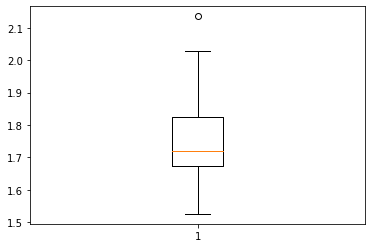

In [19]:
series = read_csv(dataset, header=0, index_col=0)
data = series.values
# data split 
n_test = 12 

# define config
config = [24, 500, 100, 100] 
# grid search 
scores = repeat_evaluate(data, config, n_test)
# summarize scores 
summarize_scores('mlp' , scores)